This code uses UL2 to 

(1) measure inconsistencies in its conditionals; 

(2) improve its inference with Emsemble of Conditionals.  



### Imports and global utils

In [1]:
'''imports'''
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,4,5,6,7"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import utils.general_utils as general_utils
# clear GPU memory
if False:   
    general_utils.kill_gpu_process(os.environ["CUDA_VISIBLE_DEVICES"])
import torch
from transformers import T5ForConditionalGeneration, AutoTokenizer, T5Tokenizer
import numpy as np
import pickle
import time
from tqdm import tqdm
from utils import eoc
from utils.lambada_utils import LambadaProcessor


/home/nus-ytj/miniconda3/envs/inconsistencies/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load tokenizer and model

In [2]:
'''Load tokenizer'''
# We are using custom huggingface cache dirs in case the default one doesn't have the capacity, since the models can be quite large.
MY_HUGGINGFACE_CACHE_DIR ='huggingface_cache' # relative to this notebook path
tokenizer = AutoTokenizer.from_pretrained("google/ul2",
                                        cache_dir = MY_HUGGINGFACE_CACHE_DIR+'/google-ul2')



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
RUN_CELL = False # Load model 0
# device_map = general_utils.get_ul2_device_map('4')
device_map = "balanced"
if RUN_CELL:
    model = T5ForConditionalGeneration.from_pretrained("google/ul2", 
                                                    cache_dir=MY_HUGGINGFACE_CACHE_DIR + '/google-ul2', 
                                                    low_cpu_mem_usage=True, 
                                                    torch_dtype=torch.bfloat16,
                                                    device_map=device_map)

### Ensemble of Conditionals

In [4]:
'''Specify set partition and UL2 mode; and instantiate the lambada processor'''
IS_DEVELOPMENT = False # Set to False to run on the test set
set_partition = 'validation_' if IS_DEVELOPMENT else 'test_' # filename part for saving results 
LAMBADA_TEST_DATA_PATH = "data/jsonls/validation.jsonl" if IS_DEVELOPMENT else "data/jsonls/test.jsonl"
UL2_MODE = "[NLG]"

processor = LambadaProcessor(tokenizer, 
                             ul2_mode=UL2_MODE, 
                             lambada_dataset_path=LAMBADA_TEST_DATA_PATH, 
                             rm_punc_space=True)
ce_loss = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id) #reduction='avg'
ce_loss_sum = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id, reduction='sum') #reduction='sum'
lambada = processor.dataset


Strategy for different punctuations
<details>
<summary>click to expand</summary>

In the LAMBADA last word prediction task, natural language models (LLMs) may append various punctuations to the same last word, leading to different completions. For example, to complete the sentence "My color of my pet dog is":

Possible Completions:

1. _white._ with probability `p_1`
2. _white!_ with probability `p_2` (assuming `p_1 > p_2`)
3. _black,_ with probability `p_3`
4. _black?_ with probability `p_4` (assuming `p_3 > p_4`)

Strategies to Rank _white_ and _black_:

1. Maximum Probability Strategy

- Probability of _white_: `p(white) = p_1`
- Probability of _black_: `p(black) = p_3`

2. Sum of Probabilities Strategy

- Probability of _white_: `p(white) = p_1 + p_2`
- Probability of _black_: `p(black) = p_3 + p_4`

Afterwards `p(_white_)` and `p(_black_)` may need normalization.

WE ARE STICKING WITH MAXIMUM PROBABILITY STRAGEGY ACCORDING TO ACCURACIES OBTAINED FROM TRIAL RUNS. 

In [5]:
RUN_CELL = False # '''Generate the top completions (through beam search) for each example, and get the word from each completion.'''
if RUN_CELL:
    # generate for all examples, and then get the words from the completions, and compare the first one with the target
    count_correct = 0 # No. correct last word predictions if only the top completion is considered
    count_correct_top_num_beams = 0 # ... if the top num_beams completions are considered
    count_no_words_found = 0  # No. examples where no valid last word is found

    # punctuated_word: the last word and the punctuation that follows it
    id_to_punctuated_words = {} # maps example index to a list of word and punc pairs; every punc is kept for each word
    id_to_completions_ids = {}

    MAX_COMPLETION_LENGTH = 8 # for last word prediction, 8 is sufficient
    NUM_BEAMS = 20 # 20 is sufficient; more doesn't help

    # for example_index in tqdm(range(10)): # len(lambada)
    for example_index in tqdm(range(len(lambada))): # len(lambada)
        input_string = lambada[example_index]['inputs_pretokenized']
        inputs = tokenizer(input_string, return_tensors="pt").input_ids.to("cuda")
        outputs = model.generate(inputs,
                                max_length=MAX_COMPLETION_LENGTH, 
                                num_beams=NUM_BEAMS, 
                                num_return_sequences=NUM_BEAMS, 
                                output_scores=True,
                                eos_token_id=tokenizer.convert_tokens_to_ids('<extra_id_1>'), 
                                return_dict_in_generate=True)
        
        completions = [tokenizer.decode(outputs['sequences'][i]) for i in range(NUM_BEAMS)]
        completions_ids_with_valid_lastword = [
            outputs['sequences'][i].cpu()
            for i in range(NUM_BEAMS)
            if processor.get_word_from_completion(completions[i]) is not None # if the completion has a valid last word
        ]

        words = processor.get_words_from_completions(completions)
        words_unique = list(set(words))

        # TODO: combine them and move to lambada_utils.py
        completions_without_pad = processor.remove_pad_id(completions_ids_with_valid_lastword)
        completions_without_pad_before_punctuation = processor.before_first_punc_including(completions_without_pad) # including the first punc
        
        if words:
            if words[0] == lambada[example_index]['targets_pretokenized'][0]:
                count_correct += 1
        else:
            count_no_words_found += 1
            # print("no words found")
        punctuated_words = processor.get_punctuated_words(completions)
        id_to_punctuated_words[example_index] = punctuated_words
        
        completions_without_pad_before_punctuation_unique = list(set([tuple(x.numpy()) for x in completions_without_pad_before_punctuation]))
        id_to_completions_ids[example_index] = [torch.tensor(x) for x in completions_without_pad_before_punctuation_unique]

        # calculate the number of correct top num_beams: if the correct word is in the top num_beams, then it is correct
        for word in words_unique:
            if word == lambada[example_index]['targets_pretokenized'][0]:
                count_correct_top_num_beams += 1
                break
    print("count_correct", count_correct)
    # count_correct, NLU: 0.7595
    # count_correct, NLG: 0.7680 (test)
    # count_correct, S2S: 0.3743 (could be because how the mode handles extra_ids)


In [6]:
RUN_CELL = False # '''Save the beam search results by generate()'''
if RUN_CELL:
    note = ''
    filename = 'data/pkls/lambada_ul2/' + set_partition + UL2_MODE + '_ul2_lambada_vanilla_beam_search_results' + note + '.pickle'
    print('\''+filename+'\'')

    data_keys = ['count_correct', 'count_correct_top_num_beams', 'count_no_words_found',
                'id_to_punctuated_words', 'id_to_completions_ids']
    data = {}
    for key in data_keys:
        data[key] = locals()[key]

    with open(filename, 'wb') as fp:
        pickle.dump(data, fp)

In [7]:
'''Load the beam search results'''
filename = 'data/pkls/lambada_ul2/' + set_partition + UL2_MODE + '_ul2_lambada_vanilla_beam_search_results.pickle' 
with open(filename, 'rb') as fp:
    ul2_lambada_vanilla_beam_search_results = pickle.load(fp)
id_to_completions_ids = ul2_lambada_vanilla_beam_search_results['id_to_completions_ids']

Filter by completion length

In [8]:
RUN_CELL = True   # select a subset by completion length 
if RUN_CELL:
    id_to_completions_ids_subset = {}
    lambada_subset = []
    new_id_to_old_id = {}
    old_id_to_new_id = {}
    def tensors_filtering_criterion(completions_batch):
        if len(completions_batch) < 2:
            return False
        # return True
        avg_len = sum([len(general_utils.remove_trailing_zeros_from_1d_tensor(completion)) for completion in completions_batch]) / len(completions_batch)
        # return avg_len > 3.9
        return all([len(general_utils.remove_trailing_zeros_from_1d_tensor(completion)) < 100 for completion in completions_batch]) \
            and (not all([len(general_utils.remove_trailing_zeros_from_1d_tensor(completion)) < 5 for completion in completions_batch])) \
            and avg_len < 5
    new_id = 0
    for id, completions in id_to_completions_ids.items():
        if tensors_filtering_criterion(completions):
            id_to_completions_ids_subset[new_id] = completions
            lambada_subset.append(lambada[id])
            new_id_to_old_id[new_id] = id
            old_id_to_new_id[id] = new_id
            new_id += 1
    processor.dataset = lambada_subset
    lambada = lambada_subset
    id_to_completions_ids = id_to_completions_ids_subset

K-offset conditionals
<details>
<summary>Click to expand</summary>

__K-offset Ensemble__ is a particular type of __Ensemble of Conditionals__.

It aims to augment the only conditional distribution obtained by masking the last word with more distributions. The new distributions are obtained by masking the last __offset__ words.

An example with the _lambada[0]_

_lambada[0]['input_pretokenized']_: `... his mouth curved in a confident grin , i do n't care about <last_word>`

We consider candidates `['angels.', 'signs.', 'that.']`.

The baseline approach is to input `... his mouth curved in a confident grin , i do n't care about <extra_id_0>` to UL2 and obtain the distribution containing the 3 candidates.

For the offset=1 case in K-offset Ensemble, we mask an extra token `about` in the end and input instead

`... his mouth curved in a confident grin , i do n't care <extra_id_1>`

This gives us a different distribution regarding `['about angels.', 'about signs.', 'about that.']`. They are given in an autoregressive manner
e.g., `p(about angels) = p(about) * p(angels|about)`. Therefore we will use conditionals in the style of `p(angels|about)` to augment the baseline conditionals.

Cases where __K__ is larger can be similarly derived.




In [9]:
MAX_OFFSET = 15

In [10]:
RUN_CELL = False # '''Generate the offset samples'''
if RUN_CELL:
    id_and_offset_to_inputs_and_completions = \
        processor.get_offset_samples(
            id_to_completions_ids, 
            max_offset=MAX_OFFSET,
            to_gpu=True
        )

In [11]:
RUN_CELL = False # '''Save the offset samples'''
if RUN_CELL:
    note = ''
    filename = 'data/pkls/lambada_ul2/offset_samples_' + set_partition + 'max_offset_' + str(MAX_OFFSET) + note + '.pickle'
    print('\''+filename+'\'')
    with open(filename, 'wb') as fp:
        pickle.dump(id_and_offset_to_inputs_and_completions, fp)

In [12]:
RUN_CELL = False   # Load the offset samples
if RUN_CELL:
    filename = 'data/pkls/lambada_ul2/offset_samples_' + set_partition + 'max_offset_' + str(MAX_OFFSET) + '.pickle'
    with open(filename, 'rb') as fp:
        id_and_offset_to_inputs_and_completions = pickle.load(fp)

In [13]:
RUN_CELL = False  # Obtain p_map_offset
if RUN_CELL:
# id_and_offset_to_input_and_completions:
# (id, offset) -> input_ids, [completion_ids_0, completion_ids_1, completion_ids_2,...]
    p_map_offset = dict() # (id, offset, completion_index) -> avg_log_p of the tokens constituting the last word (might be punctuated)
    
    for example_index in tqdm(range(len(lambada))): 
    # for example_index in tqdm(range(1)): 
        if len(id_to_completions_ids[example_index]) == 0:
            continue
        for offset in range(MAX_OFFSET):
            completions_batch = id_and_offset_to_inputs_and_completions[(example_index, offset)]['labels']
            input_ids = id_and_offset_to_inputs_and_completions[(example_index, offset)]['inputs']
            outputs = eoc.multi_labels_forward(model, input_ids, completions_batch)

            for completion_index in range(len(id_to_completions_ids[example_index])):
                avg_log_p = -ce_loss(
                    # Only care about the tokens corresponding to the last word and omit offset tokens 
                    # the first one is <extra_id_0> and omitted
                    outputs.logits[completion_index][1+offset:], 
                    completions_batch[completion_index][1+offset:]
                )
                p_map_offset[(example_index, offset, completion_index)] = \
                    avg_log_p.detach().cpu().tolist()
    


In [14]:
RUN_CELL = False  # Save the p_map_offset
if RUN_CELL:
    note = ''
    pickle_filename = 'data/pkls/lambada_ul2/p_map_' + set_partition + 'max_offset_' + str(MAX_OFFSET) + note + '.pickle'
    print('\''+pickle_filename+'\'')
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(p_map_offset, handle)

In [15]:
RUN_CELL = True  # Load the p_map for the offset samples
if RUN_CELL:
    pickle_filename = 'data/pkls/lambada_ul2/p_map_' + set_partition +  'max_offset_' + str(MAX_OFFSET) +'.pickle'
    # p_map_offset (Dict): (id, offset, completion_index) -> avg_log_p of the tokens constituting the last word (might be punctuated)
    with open(pickle_filename, 'rb') as handle:
        p_map_offset = pickle.load(handle)

Multimask conditionals  


<details>
<summary>Click to expand</summary>

__Span-corruption Ensemble__ is a particular type of __Ensemble of Conditionals__.


It aims to augment the only conditional distribution obtained by masking a number of additional spans in the middle of the input for additional distributions. 


(inaccurate notes copied from K offset ensemble)
The key sample generation function is create_middle_off_sample() in lambada_utils, which is controlled by
`middle_span_length`: the length of the masked span in the middle
and 
`middle_to_end_gap`： the gap between the middle_span and the last word

on average, the len of a lambada completion is 4.8 (including punc and extra_token_id)

An example with the _lambada[0]_

_lambada[0]['input_pretokenized']_: `... his mouth curved in a confident grin , i do n't care about <last_word>`

We consider candidates `['angels.', 'signs.', 'that.']`.

The baseline approach is to input `... his mouth curved in a confident grin , i do n't care about <extra_id_0>` to UL2 and obtain the distribution containing the 3 candidates.



completion_lengths = [
    id_and_offset_to_inputs_and_completions[example_index,0][completion_index][1].shape[0] - 1
    for example_index in range(len(lambada)) 
    for completion_index in range(len(id_and_offset_to_inputs_and_completions[example_index,0]))
] 
np.mean(completion_lengths) == 3.8


In [16]:
# Param. for getting span-corruption (multispan) samples
# num_spans_decision_method = 'auto'
num_spans_decision_method = 'manual'
if num_spans_decision_method == 'auto':
    LENGTH_GAP_NUM_TUPLE = (3, 5, None)
    AUTO_RATIO = 0.1
    multiple_spans_filename_part = 'length_3_gap_5_numspan_auto_point_1'
else:
    LENGTH_GAP_NUM_TUPLE = (3, 8, 1)
    AUTO_RATIO = None
    # auto generates the part
    multiple_spans_filename_part = 'length_' + str(LENGTH_GAP_NUM_TUPLE[0]) + '_gap_' + str(LENGTH_GAP_NUM_TUPLE[1]) + '_numspan_' + str(LENGTH_GAP_NUM_TUPLE[2])



In [17]:
RUN_CELL = False # Generate the multispan samples
if RUN_CELL:
    # id_span_gap_num_to_input_and_completions: maps (id, span_length, gap_between_spans, num_spans) to a input_ids(Tensor) and multiple completion_ids(List[Tensor])
    id_span_gap_num_to_input_and_completions = \
        processor.get_multiple_span_samples(
            id_to_completions_ids, 
            length_gap_num_tuple=LENGTH_GAP_NUM_TUPLE,
            to_gpu=False,
            auto_ratio=AUTO_RATIO
        )
# INFO: input length range: 70 ~ 234

In [18]:
RUN_CELL = False # Obtain the p_map for multispan samples
if RUN_CELL:
    # id_span_gap_num_to_input_and_completions: maps (id, span_length, gap_length, num_spans) to a input_ids(Tensor) and completion_ids(List[Tensor])
    # p_map_multiple_spans: maps (id, middle_span_length, middle_to_end_gap, completion_index) to avg_log_p of the tokens constituting the last word (might be punctuated)
    p_map_multiple_spans = dict()
    for id_span_gap_num in tqdm(id_span_gap_num_to_input_and_completions):
        input_ids = id_span_gap_num_to_input_and_completions[id_span_gap_num]['inputs'].unsqueeze(0).to("cuda")
        completions_batch = id_span_gap_num_to_input_and_completions[id_span_gap_num]['labels'].to("cuda")
        outputs = eoc.multi_labels_forward(model, input_ids, completions_batch)

        span_length = id_span_gap_num[1]
        if num_spans_decision_method == 'auto':
            num_spans = processor.calculate_num_spans(
                id_span_gap_num[0], 
                span_length, 
                id_span_gap_num[2], 
                id_span_gap_num[3],  # auto ratio
                max_num_spans = 99
            )
        elif num_spans_decision_method == 'manual':
            num_spans = id_span_gap_num[3]
        else:
            raise ValueError('num_spans_decision_method must be either \'auto\' or \'manual\'')

        for completion_index in range(len(completions_batch)):
            avg_log_p = -ce_loss(
                # Only care about the tokens corresponding to the last word (see assert below)); 
                # so the first <extra_id_0> is omitted, and for each span, the span + <extra_id_k> is omitted;
                # totally 1 + num_spans * (span_length + 1) tokens are omitted;
                # contains paddings.
                outputs.logits[completion_index][1 + num_spans * (span_length + 1) :], 
                completions_batch[completion_index][1 + num_spans * (span_length + 1) :]
            )
            
            assert id_to_completions_ids[id_span_gap_num[0]][completion_index].shape[0] - 1 == \
                completions_batch[completion_index][1 + num_spans * (span_length + 1) :].nonzero().shape[0]

            p_map_multiple_spans[(*id_span_gap_num, completion_index)] = \
                avg_log_p.detach().cpu().tolist()    
            


In [19]:
RUN_CELL = False # Save the p_map_multiple_spans
if RUN_CELL:
    pickle_filename = 'data/pkls/lambada_ul2/p_map_multiple_spans_' + set_partition + multiple_spans_filename_part + '.pickle'
    print('\'' + pickle_filename + '\'')
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(p_map_multiple_spans, handle)

In [20]:
RUN_CELL = True   # Load the p_map_multiple_spans
if RUN_CELL:
    # load multiple dicts and combine them.
    multispan_types = [
        'length_3_gap_5_numspan_1',
        'length_3_gap_5_numspan_2',
        # 'length_3_gap_5_numspan_3',
        # 'length_3_gap_5_numspan_4',
        # 'length_3_gap_5_numspan_5',
        'length_3_gap_8_numspan_1',
        'length_3_gap_10_numspan_1',
        # 'length_3_gap_15_numspan_1',
        # 'length_3_gap_20_numspan_1',
        # 'length_3_gap_25_numspan_1',
        # 'length_3_gap_30_numspan_1',
        # 'length_3_gap_35_numspan_1',
        # 'length_3_gap_40_numspan_1',
        # 'length_3_gap_45_numspan_1',
        # 'length_3_gap_5_numspan_auto_point_3',
        # 'length_3_gap_5_numspan_auto_point_1'
    ]
    filenames = [
        'data/pkls/lambada_ul2/p_map_multiple_spans_' + set_partition + multispan_type + '.pickle'
        for multispan_type in multispan_types
    ]
    p_map_multiple_spans = dict()
    for filename in filenames:
        with open(filename, 'rb') as handle:
            p_map_multiple_spans.update(pickle.load(handle))

Filter saved p_maps by length

In [21]:
RUN_CELL = True  # Filter saved p_maps by length
if RUN_CELL:
    p_map_offset_new = {}
    for key in p_map_offset:
        old_example_index = key[0]
        if old_example_index in old_id_to_new_id:
            new_example_index = old_id_to_new_id[old_example_index]
            p_map_offset_new[(new_example_index, key[1], key[2])] = p_map_offset[key]
    p_map_offset = p_map_offset_new

    p_map_multiple_spans_new = {}
    for key in p_map_multiple_spans:
        old_example_index = key[0]
        if old_example_index in old_id_to_new_id:
            new_example_index = old_id_to_new_id[old_example_index]
            p_map_multiple_spans_new[(new_example_index, key[1], key[2], key[3], key[4])] = p_map_multiple_spans[key]
    p_map_multiple_spans = p_map_multiple_spans_new

Ensemble

In [22]:
'''Define the EOC function'''
# Max reduction to emsemble conditionals for the same last word
'''Max reduction to emsemble conditionals for the same last word, 
i.e., only the maximum avg_log_p is kept for each last word across different range_middle_span_length's and range_middle_to_end_gap's.
Emsemble the baseline conditionals with the K-offset conditionals and middle-off conditionals.'''

def run_eoc(
    offsets,
    length_gap_num_tuples,
):  
    # Add the baseline (offset = 0 from K-offset ensemble) to the list
    add_baseline = True
    add_k_offset = offsets != []
    add_multispan = length_gap_num_tuples != []
    count_correct = 0
    for example_index in range(len(lambada)): # len(lambada)
        # Create a list of tuples (avg_log_p, completion) for each completion
        p_and_completion = []
                
        # add the baseline (offset = 0 from K-offset ensemble) to the list
        if add_baseline:
            p_and_completion += [
                (p_map_offset[(example_index, 0, completion_index)], id_to_completions_ids[example_index][completion_index])
                for completion_index in range(len(id_to_completions_ids[example_index]))
            ]
            
        # add the whole K-offset ensemble to the list
        if add_k_offset:
            for offset in offsets:
                p_and_completion += [
                    (p_map_offset[(example_index, offset, completion_index)], id_to_completions_ids[example_index][completion_index])
                    for completion_index in range(len(id_to_completions_ids[example_index]))
                ]
                
        if add_multispan:
            p_and_completion += [
                (p_map_multiple_spans[(example_index, *length_gap_num, completion_index)], id_to_completions_ids[example_index][completion_index])
                for completion_index in range(len(id_to_completions_ids[example_index]))
                for length_gap_num in length_gap_num_tuples
            ]
            
        if len(p_and_completion) == 0: # if no completions are found
            continue
        # Find the tuple with the maximum avg_log_p; this is essentially max reduction
        best_avg_log_p, best_word = max(p_and_completion, key=lambda x: x[0])
        if processor.is_correct_result(example_index, best_word):
            count_correct += 1
    # print("accuracy:", count_correct / len(lambada))
    return count_correct / len(lambada)

In [43]:
from itertools import combinations
import random        
RUN_CELL = True  # Run EOC
if RUN_CELL:
    avg_accs = []
    NO_DISTS_RANGE = list(range(10))
    for NO_DISTS in NO_DISTS_RANGE: # no of distributions to ensemble
        # K-offset conditionals
        ALL_OFFSETS = [1, 2, 3, 4, 5, 6,]
        # Multispan conditionals
        ALL_LENGTH_GAP_NUM_TUPLES = [
            (3, 5, 1), 
            (3, 5, 2), 
            (3, 10, 1),
        ]
        NO_OFFSETS = len(ALL_OFFSETS)
        NO_MULTISPAN = len(ALL_LENGTH_GAP_NUM_TUPLES)
        all_dist_ids = list(combinations(range(NO_MULTISPAN + NO_OFFSETS), NO_DISTS))
        # shuffle and take the first 100
        random.shuffle(all_dist_ids)
        all_dist_ids = all_dist_ids[:500]
        all_accs = []
        for dist_ids in all_dist_ids:
            offsets = []
            length_gap_num_tuples = []
            for dist_id in dist_ids:
                if dist_id < NO_OFFSETS:
                    offsets.append(ALL_OFFSETS[dist_id])
                else:
                    length_gap_num_tuples.append(ALL_LENGTH_GAP_NUM_TUPLES[dist_id - NO_OFFSETS])            
            acc = run_eoc(
                offsets,
                length_gap_num_tuples,
            )
            # print offsets and length_gap_num_tuples and acc
            # print(offsets, length_gap_num_tuples, acc)
            all_accs.append(acc)
        avg_acc = sum(all_accs) / len(all_accs)
        avg_accs.append(avg_acc)
        # print number of dists and avg_acc
        print(f"NO_DISTS: {NO_DISTS}, avg_acc: {avg_acc}")

NO_DISTS: 0, avg_acc: 0.7141608391608392
NO_DISTS: 1, avg_acc: 0.7263986013986014
NO_DISTS: 2, avg_acc: 0.7295794483294484
NO_DISTS: 3, avg_acc: 0.7315705128205129
NO_DISTS: 4, avg_acc: 0.7333846708846715
NO_DISTS: 5, avg_acc: 0.7350566100566107
NO_DISTS: 6, avg_acc: 0.7365759240759243
NO_DISTS: 7, avg_acc: 0.7379564879564882
NO_DISTS: 8, avg_acc: 0.7392191142191141
NO_DISTS: 9, avg_acc: 0.7403846153846154


### Plot

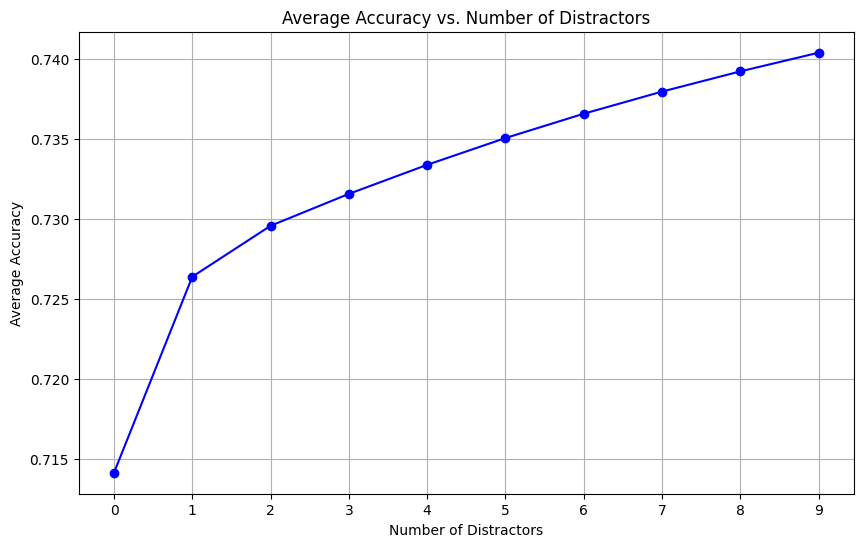

In [50]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(NO_DISTS_RANGE, avg_accs, marker='o', linestyle='-', color='blue')
plt.title('Average Accuracy vs. Number of Distractors')
plt.xlabel('Number of Distractors')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(NO_DISTS_RANGE)
# /data/personal/nus-ytj/MLM_inconsistencies/publication/pics/ul2_lambada_acc_vs_no_dists.png
plt.savefig('/data/personal/nus-ytj/MLM_inconsistencies/publication/pics/ul2_lambada_acc_vs_no_dists.png')
plt.show()

### End of main code

In [ ]:
RUN_CELL = False # Quantify disagreement on last word predictions among K-offset conditionals
if RUN_CELL: 
    for NUM_CONDITIONALS in range(2, 6): # 2, 3, 4, 5; how many sets of conditionals to consider; offset = 0 and offset = 1 are 2 different sets of conditionals
        id_offset_to_lastword = dict()
        id_to_lastwords_by_offsets = dict()
        for offset in range(NUM_CONDITIONALS): # if NUM_CONDITIONALS = 2, then offset = 0, 1
            for example_index in range(len(lambada)): # len(lambada)
                # Create a list of tuples (avg_log_p, completion) for each completion
                p_and_completion = [
                    (p_map_offset[(example_index, offset, completion_index)], id_to_completions_ids[example_index][completion_index])
                    for completion_index in range(len(id_to_completions_ids[example_index]))
                ]
                if len(p_and_completion) == 0:
                    continue
                # Find the tuple with the maximum avg_log_p; this is essentially max reduction
                best_avg_log_p, best_completion = max(p_and_completion, key=lambda x: x[0])
                lastword = processor.get_word_from_completion(tokenizer.decode(best_completion))
                id_offset_to_lastword[(example_index, offset)] = lastword
                if example_index not in id_to_lastwords_by_offsets:
                    id_to_lastwords_by_offsets[example_index] = []
                id_to_lastwords_by_offsets[example_index].append(lastword)
        no_disagreement_count = 0
        for example_index in id_to_lastwords_by_offsets:
            if len(set(id_to_lastwords_by_offsets[example_index])) > 1:
                no_disagreement_count += 1
        ratio_disagreement = no_disagreement_count / (len(lambada) - ul2_lambada_vanilla_beam_search_results['count_no_words_found'])
        print("NUM_CONDITIONALS", NUM_CONDITIONALS, "ratio_disagreement", ratio_disagreement)

In [ ]:
general_utils.kill_gpu_process(os.environ["CUDA_VISIBLE_DEVICES"])
